In [ ]:
!pip install --no-cache-dir git+https://github.com/f21nl-heriot-watt/f21nl-cw2

  Cloning https://github.com/f21nl-heriot-watt/f21nl-cw2 to /tmp/pip-req-build-ywp712wa
  Running command git clone --filter=blob:none --quiet https://github.com/f21nl-heriot-watt/f21nl-cw2 /tmp/pip-req-build-ywp712wa
  Resolved https://github.com/f21nl-heriot-watt/f21nl-cw2 to commit c64767272389d7e7bcfb2a1c0c7f3654871bd491
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 368.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 284.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 275.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 216.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 284.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776

In [ ]:
from f21nl.decoding_strategies import DecodingStrategy
import torch

class TopKDecoding(DecodingStrategy):
    def __init__(self, top_k: int = 2):
        self._top_k = top_k
        self._filter_value = -float("Inf")

    def __call__(self, step_logits: torch.Tensor) -> torch.Tensor:
        probabilities = torch.softmax(step_logits, dim=-1)

        top_k_probs, top_k_indices = torch.topk(probabilities, self._top_k)

        sampled_indices = torch.multinomial(top_k_probs, 1)
        return top_k_indices.gather(-1, sampled_indices).squeeze()


class TopPDecoding(DecodingStrategy):
    def __init__(self, top_p: float = 0.95):
        if top_p < 0.0 or top_p > 1.0:
            raise ValueError("top_p must be between 0.0 and 1.0!")

        self._top_p = top_p
        self._filter_value = -float("Inf")

    def __call__(self, step_logits: torch.Tensor) -> torch.Tensor:
        batch_size = step_logits.size(0)
        selected_indices = []

        for i in range(batch_size):
            logits = step_logits[i]
            probabilities = torch.softmax(logits, dim=-1)
            sorted_probs, sorted_indices = probabilities.sort(descending=True)

            cumulative_probs = sorted_probs.cumsum(dim=-1)
            filtered_indices = cumulative_probs <= self._top_p

            valid_indices = sorted_indices[filtered_indices]

            if valid_indices.numel() > 0:
                filtered_probs = probabilities[filtered_indices]

                sampled_prob_index = torch.multinomial(filtered_probs, 1)

                sampled_index = valid_indices[sampled_prob_index]
                selected_indices.append(sampled_index)
            else:
                selected_indices.append(sorted_indices[0:1])


        return torch.cat(selected_indices).squeeze()


In [ ]:
# @title Your Custom NMT Encoder Decoder

from f21nl.lightning_modules.nmt_seq2seq import NMTModule
from f21nl.model_components.encoder_decoder import NMTEncoderDecoder, NMTEncoder, NMTDecoder
from f21nl.interfaces import EncoderDecoderConfig
from f21nl.decoding_strategies import GreedyDecoding
from torch import nn
import torch
from torchmetrics.text import BLEUScore
from tokenizers import Tokenizer

class CustomNMTEncoderDecoder(NMTEncoderDecoder):
    def __init__(
        self,
        config: EncoderDecoderConfig,
        source_tokenizer: Tokenizer,
        target_tokenizer: Tokenizer,
        max_decoding_steps: int = 20,

    ) -> None:

        super().__init__(config=config, source_tokenizer=source_tokenizer, target_tokenizer=target_tokenizer)

        self._config = config

        self.encoder: NMTEncoder = NMTEncoder(
            encoder_cell_type=config.encoder_config.encoder_cell_type,
            encoder_input_dim=config.encoder_config.encoder_input_dim,
            encoder_output_dim=config.encoder_config.encoder_output_dim,
            source_vocab_size=source_tokenizer.get_vocab_size(),
            source_embedding_dim=config.encoder_config.source_embedding_dim,
            bidirectional=config.encoder_config.bidirectional,
        )
        self.decoder: NMTDecoder = NMTDecoder(
            decoder_cell_type=config.decoder_config.decoder_cell_type,
            decoder_input_dim=config.decoder_config.decoder_input_dim,
            decoder_output_dim=config.decoder_config.decoder_output_dim,
            target_vocab_size=target_tokenizer.get_vocab_size(),
            target_embedding_dim=config.decoder_config.target_embedding_dim,
        )

        # We project the hidden state from the decoder into the output vocabulary space
        # in order to get log probabilities of each target token, at each time step.
        self._output_projection_layer = nn.Linear(
            config.decoder_config.decoder_output_dim, target_tokenizer.get_vocab_size()
        )

        self._start_index = target_tokenizer.encode("[BOS]").ids[0]
        self._max_decoding_steps = max_decoding_steps
        self._attention = config.attention
        #bilinear weight matrix initialization
        if self._attention == "bilinear":
            self.attn_weight_matrix = nn.Parameter(torch.empty(config.decoder_config.decoder_output_dim, config.decoder_config.decoder_output_dim))
            nn.init.xavier_uniform_(self.attn_weight_matrix)


        if config.decoding_strategy.name == "greedy":
            self.decode_strategy = GreedyDecoding()
        elif config.decoding_strategy.name == "top_k":
            self.decode_strategy = TopKDecoding(top_k=config.decoding_strategy.top_k)
        elif config.decoding_strategy.name == "top_p":
            self.decode_strategy = TopPDecoding(top_p=config.decoding_strategy.top_p)
        else:
            raise NotImplementedError("You still haven't implemented your decoding strategy!")


    def _compute_attention(
        self,
        decoder_hidden_state: torch.Tensor,
        encoder_outputs: torch.Tensor,
        encoder_outputs_mask: torch.Tensor,
    ) -> torch.Tensor:
        batch_size, seq_len, encoder_dim = encoder_outputs.size()
        decoder_dim = decoder_hidden_state.size(-1)

        attention_scores = torch.zeros(batch_size, seq_len, device=encoder_outputs.device)

        if self._attention == "dot_product":
            attention_scores = torch.bmm(encoder_outputs, decoder_hidden_state.unsqueeze(2)).squeeze(2)

        elif self._attention == "bilinear":
            transformed_decoder_hidden = torch.matmul(decoder_hidden_state, self.attn_weight_matrix)
            attention_scores = torch.bmm(encoder_outputs, transformed_decoder_hidden.unsqueeze(2)).squeeze(2)


        else:
            raise ValueError(f"Attention mechanism of type {self._attention} not supported yet!")

        attention_scores.masked_fill_(encoder_outputs_mask == 0, float('-inf'))

        attention_weights = torch.softmax(attention_scores, dim=1)

        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return context_vector, attention_weights



In [ ]:
# @title Lightning module for our NMT model

class CustomNMTModule(NMTModule):
    """An example lightning module."""

    def __init__(
        self,
        config: EncoderDecoderConfig,
        source_tokenizer: Tokenizer,
        target_tokenizer: Tokenizer,
        *,
        optimizer_partial_fn = torch.optim.Adam,
    ) -> None:
        super().__init__(config=config, source_tokenizer=source_tokenizer, target_tokenizer=target_tokenizer)

        self.config = config
        self.model = None
        self.loss_function = torch.nn.CrossEntropyLoss(reduction="none")

        self._optimizer_partial_fn = optimizer_partial_fn

        self._source_tokenizer = source_tokenizer
        self._target_tokenizer = target_tokenizer

        if config.use_bleu:
            self._bleu = BLEUScore()
            self._predictions = []
            self._references = []
        else:
            self._bleu = None

        # We build your custom model here!
        self.model = CustomNMTEncoderDecoder(
            self.config,
            source_tokenizer=self._source_tokenizer,
            target_tokenizer=self._target_tokenizer,
        )

        self._end_index = self._target_tokenizer.encode("[EOS]").ids[0]
        self.save_hyperparameters(config._asdict())

In [ ]:
from typing import NamedTuple
from f21nl.interfaces import DatasetSize
from pathlib import Path

class TrainConfig(NamedTuple):
    """Training configuration."""
    train_epochs: int = 10
    checkpoint_dirpath: Path = Path("storage/checkpoints/")
    use_early_stopping: bool = False
    early_stopping_monitor: str = "valid_loss"
    eary_stopping_mode: str = "min"


class DataConfig(NamedTuple):
    """Data configration."""
    dataset_size: DatasetSize
    storage_dir: Path = Path("storage/data")
    batch_size: int = 4
    num_workers: int = 0


In [ ]:
from pathlib import Path

from lightning import seed_everything, Trainer
from f21nl.interfaces import EncoderDecoderConfig, DecodingStrategyConfig, EncoderConfig, DecoderConfig
from f21nl.datamodule import Multi30kDataModule
from f21nl.lightning_modules.nmt_seq2seq import NMTModule
from f21nl.callbacks import NMTCallbacks


def train(data_config: DataConfig, model_config: EncoderDecoderConfig, train_config: TrainConfig) -> None:
    """Run the training loop."""
    seed_everything(42, workers=True)

    dm = Multi30kDataModule(
        dataset_size=DatasetSize[data_config.dataset_size],
        storage_dir=data_config.storage_dir,
        batch_size=data_config.batch_size,
        num_workers=data_config.num_workers,
    )

    dm.prepare_data()
    dm.setup("fit")
    model = CustomNMTModule(model_config, dm.source_tokenizer, dm.target_tokenizer)

    trainer = Trainer(
        max_epochs=train_config.train_epochs,
        callbacks=NMTCallbacks(
            checkpoint_dirpath=train_config.checkpoint_dirpath,
            use_early_stopping=train_config.use_early_stopping,
            early_stopping_monitor=train_config.early_stopping_monitor,
            eary_stopping_mode=train_config.eary_stopping_mode,
        ),
    )

    trainer.fit(model=model, datamodule=dm)

In [ ]:
data_config = DataConfig(
    dataset_size="large",
    storage_dir=Path("storage/data/"),
    batch_size=4,
)


train_config = TrainConfig(
    train_epochs=5,
    checkpoint_dirpath=Path("storage/checkpoints/"),
    use_early_stopping=True,
    early_stopping_monitor="valid_bleu_score",
    eary_stopping_mode="max",

)
model_config = EncoderDecoderConfig(
    encoder_config=EncoderConfig(
        encoder_cell_type="lstm",
        encoder_input_dim=50,
        encoder_output_dim=100,
        source_embedding_dim=50,
        bidirectional=True,
    ),
    decoder_config=DecoderConfig(
        decoder_cell_type="lstm",
        decoder_input_dim=520,
        decoder_output_dim=200,
        target_embedding_dim=50,
    ),
    use_bleu=True,
    attention="dot_product",
    decoding_strategy=DecodingStrategyConfig(name="greedy", top_k=5)
)



train(data_config=data_config, model_config=model_config, train_config=train_config)

In [ ]:
# TODO: set this with the checkpoint you want to evaluate
# # TODO: don't forget to use the correct checkpoint here
# Checkpoint files have extension ".ckpt"
checkpoint_path = Path("/content/storage/checkpoints/epoch=3_valid_loss=2.75_valid_bleu_score=0.1094.ckpt")

In [ ]:
from f21nl.interfaces import EncoderConfig, DecoderConfig
from f21nl.decoding_strategies import DecodingStrategy

def test(checkpoint_path : Path, data_config: DataConfig, model_config: EncoderDecoderConfig):
    dm = Multi30kDataModule(
        dataset_size=data_config.dataset_size,
        storage_dir=data_config.storage_dir,
        batch_size=data_config.batch_size,
    )

    dm.setup("test")

    model = CustomNMTModule.load_from_checkpoint(
        checkpoint_path=checkpoint_path,
        config=model_config,
        source_tokenizer=dm.source_tokenizer,
        target_tokenizer=dm.target_tokenizer,
    )

    trainer = Trainer()

    trainer.test(model=model, datamodule=dm)


In [ ]:
data_config = DataConfig(
    dataset_size=DatasetSize.large,
    storage_dir=Path("storage/data/"),
    batch_size=4,
)

model_config = EncoderDecoderConfig(
    encoder_config=EncoderConfig(
        encoder_cell_type="lstm",
        encoder_input_dim=50,
        encoder_output_dim=100,
        source_embedding_dim=50,
        bidirectional=True,
    ),
    decoder_config=DecoderConfig(
        decoder_cell_type="lstm",
        decoder_input_dim=250,
        decoder_output_dim=200,
        target_embedding_dim=50,
    ),
    use_bleu=True,
    attention= "dot_product",
    decoding_strategy=DecodingStrategyConfig(name="greedy", top_k=5)
)

In [ ]:
dddtest(checkpoint_path, data_config, model_config)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
2023-11-30 23:54:44.891 | INFO     | f21nl.data_preparation:run_data_preparation:154 - Download the tokenized corpora
2023-11-30 23:54:44.892 | DEBUG    | f21nl.data_preparation:download_file:50 - storage/data/multi30k-en-fr-large/train.lc.norm.tok.en already exists. Skipping download...
2023-11-30 23:54:44.894 | DEBUG    | f21nl.data_preparation:download_file:50 - storage/data/multi30k-en-fr-large/train.lc.norm.tok.fr already exists. Skipping download...
2023-11-30 23:54:44.895 | DEBUG    | f21

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_bleu_score      │     0.036049984395504     │
└───────────────────────────┴───────────────────────────┘

Example 1:
Source Sentence: a group of men are loading cotton onto a truck 
Gold Translation: un groupe d'hommes chargent du coton dans un camion 
Predicted Translation: un homme se repose dans une entrée de groupe d & apos ; un camion



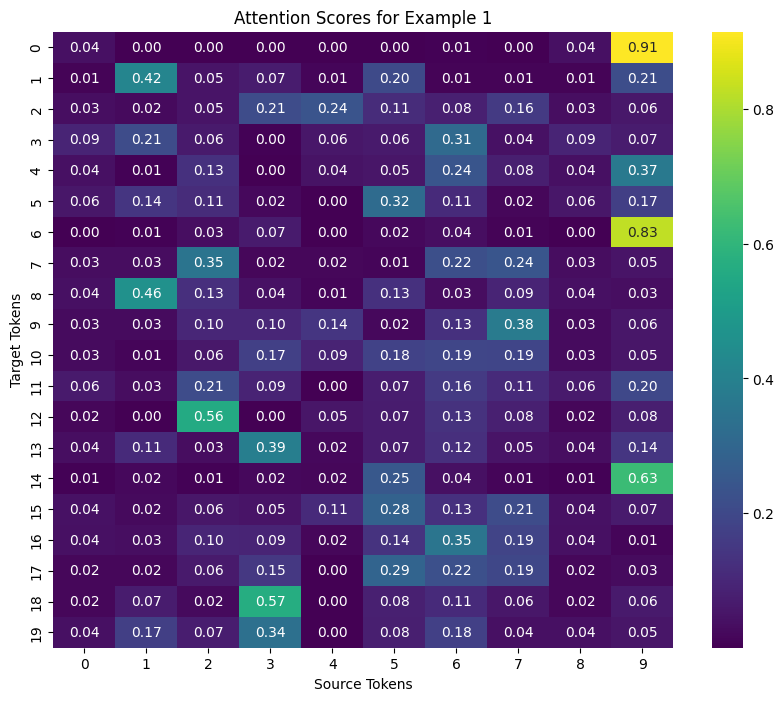

Example 2:
Source Sentence: a boy wearing headphones sits on a woman's shoulders . 
Gold Translation: un garçon avec un casque est assis sur les épaules d'une femme . 
Predicted Translation: un garçon portant des lunettes est assis sur un échafaudage . . . . .



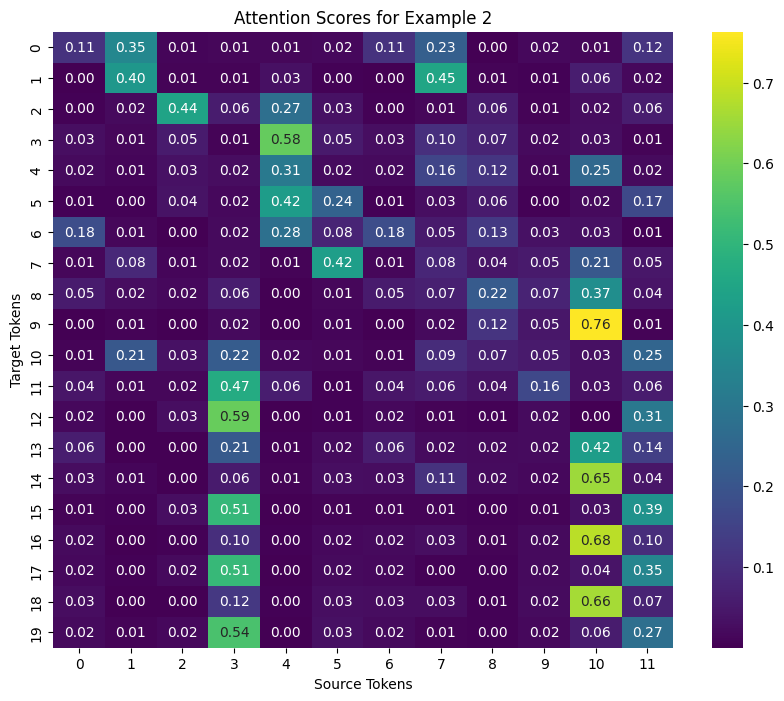

In [ ]:


from pathlib import Path
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from tokenizers import Tokenizer
from f21nl.interfaces import ModelInstance, DataConfig, EncoderDecoderConfig, EncoderConfig, DecoderConfig, DecodingStrategyConfig, DatasetSize

# Function to provide example sentences
def example_sentences() -> tuple[str, str]:
	"""Return some example sentences."""
	return [
    	"a group of men are loading cotton onto a truck ",
    	"a boy wearing headphones sits on a woman's shoulders . ",
	], [
    	"un groupe d'hommes chargent du coton dans un camion ",
    	"un garçon avec un casque est assis sur les épaules d'une femme . ",
	]

output_attention_folder = Path("storage/plots/")
output_attention_folder.mkdir(parents=True, exist_ok=True)

data_config = DataConfig(
	dataset_size="large",
	storage_dir=Path("storage/data/"),
	batch_size=2,
)

model_config = EncoderDecoderConfig(
    encoder_config=EncoderConfig(
        encoder_cell_type="lstm",
        encoder_input_dim=50,
        encoder_output_dim=100,
        source_embedding_dim=50,
        bidirectional=True,
    ),
    decoder_config=DecoderConfig(
        decoder_cell_type="lstm",
        decoder_input_dim=250,
        decoder_output_dim=200,
        target_embedding_dim=50,
    ),
    use_bleu=True,
    attention="dot_product",
    decoding_strategy=DecodingStrategyConfig(name="greedy", top_k=5)
)


storage_dir = Path("storage/data/")
language_pairs = {"source": "en", "target": "fr"}

source_tokenizer_file = storage_dir.joinpath(DatasetSize.large.value).joinpath(
	f"tokenizer-{language_pairs['source']}"
)
source_tokenizer = Tokenizer.from_file(source_tokenizer_file.as_posix())

target_tokenizer_file = storage_dir.joinpath(DatasetSize.large.value).joinpath(
	f"tokenizer-{language_pairs['target']}"
)
target_tokenizer = Tokenizer.from_file(target_tokenizer_file.as_posix())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = "/content/storage/checkpoints/epoch=4_valid_loss=1.87_valid_bleu_score=0.1999.ckpt"


model = CustomNMTModule.load_from_checkpoint(
	checkpoint_path=checkpoint_path,
	config=model_config,
	source_tokenizer=source_tokenizer,
	target_tokenizer=target_tokenizer,
	map_location=device,
)

model.eval()

source_data, target_data = example_sentences()
for idx, (raw_source_data, raw_target_data) in enumerate(zip(source_data, target_data)):
	source_encoding = source_tokenizer.encode(raw_source_data)
	target_encoding = target_tokenizer.encode(raw_target_data)

	source_tokens = torch.tensor(source_encoding.ids, dtype=torch.long).unsqueeze(0).to(device)
	source_attention_mask = torch.tensor(source_encoding.attention_mask, dtype=torch.bool).unsqueeze(0).to(device)

	batch = ModelInstance(
    	source_tokens=source_tokens,
    	source_attention_mask=source_attention_mask,
	)

	with torch.no_grad():
			output = model.predict_step(batch, 0)

	attention_scores = output['attentions'][0].cpu().numpy()

	if 'predicted_tokens' in output:
			predicted_translation = output['predicted_tokens'][0]
	else:
			predicted_translation = "Predicted translation key not found in model output"

	print(f"Example {idx + 1}:")
	print(f"Source Sentence: {raw_source_data}")
	print(f"Gold Translation: {raw_target_data}")
	print(f"Predicted Translation: {predicted_translation}\n")

	plt.figure(figsize=(10, 8))
	sns.heatmap(attention_scores, annot=True, fmt=".2f", cmap="viridis")
	plt.xlabel('Source Tokens')
	plt.ylabel('Target Tokens')
	plt.title(f'Attention Scores for Example {idx + 1}')
	plt.savefig(output_attention_folder / f"attention_example_{idx + 1}.png")
	plt.show()
